# MQ-2 

## Empty Room Analysis

### Specifications

#### Standard Work Condition

    Vc (Circuit Voltage)       :  5v +/- 0.1
    Vh (Heating Voltage)       :  5v +/- 0.1
    Rl (Load Resistance)       :  can adjust
    Rh (Heater Resistance)     :  33 ohm +/- 5%
    Ph (Heating consumption)   :  less than 800mw
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 3kOhm  -  30kOhm (1000ppm iso-butane)
    Preheat Time               : Over 24 hour
    
    Detecting Concentration Scope:
        LPG and Propane:  200ppm  - 5000ppm 
        Butane:           300ppm  - 5000ppm  
        Methane:          5000ppm - 20000ppm 
        H2:               300ppm  - 5000ppm 
        Alcohol:          100ppm  - 2000ppm

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [28]:
## Gas concentration values referenced in the datasheet

POINTS = {
    # Hydrogen
    'h2' : { 
        'p1': {'x': 200,   'y': 2.063},
        'p2': {'x': 500,   'y': 1.346},
        'p3': {'x': 800,   'y': 1.090},
        'p4': {'x': 1000,  'y': 1.000},
        'p5': {'x': 1500,  'y': 0.820},
        'p6': {'x': 2000,  'y': 0.716},
        'p7': {'x': 3000,  'y': 0.580},
        'p8': {'x': 5000,  'y': 0.458},
        'p9': {'x': 10000, 'y': 0.328}
    },  
    # Liquefied Petroleum Gas
    'lpg' : {
        'p1': {'x': 200,   'y': 1.589},
        'p2': {'x': 500,   'y': 1.044},
        'p3': {'x': 800,   'y': 0.867},
        'p4': {'x': 1000,  'y': 0.771},
        'p5': {'x': 1500,  'y': 0.648},
        'p6': {'x': 2000,  'y': 0.562},
        'p7': {'x': 3000,  'y': 0.461},
        'p8': {'x': 5000,  'y': 0.358},
        'p9': {'x': 10000, 'y': 0.256}
    },
    # Methane
    'ch4' : {
        'p1': {'x': 200,   'y': 3.028},
        'p2': {'x': 500,   'y': 2.236},
        'p3': {'x': 800,   'y': 1.880},
        'p4': {'x': 1000,  'y': 1.746},
        'p5': {'x': 1500,  'y': 1.505},
        'p6': {'x': 2000,  'y': 1.346},
        'p7': {'x': 3000,  'y': 1.139},
        'p8': {'x': 5000,  'y': 0.928},
        'p9': {'x': 10000, 'y': 0.694}
    },
    # Carbon Monoxide
    'co' : {
        'p1': {'x': 200,   'y': 5.125},
        'p2': {'x': 500,   'y': 3.903},
        'p3': {'x': 800,   'y': 3.343},
        'p4': {'x': 1000,  'y': 3.104},
        'p5': {'x': 1500,  'y': 2.709},
        'p6': {'x': 2000,  'y': 2.484},
        'p7': {'x': 3000,  'y': 2.154},
        'p8': {'x': 5000,  'y': 1.789},
        'p9': {'x': 10000, 'y': 1.388}
    },  
    'alcohol' : {
        'p1': {'x': 200,   'y': 2.829},
        'p2': {'x': 500,   'y': 2.025},
        'p3': {'x': 800,   'y': 1.713},
        'p4': {'x': 1000,  'y': 1.581},
        'p5': {'x': 1500,  'y': 1.380},
        'p6': {'x': 2000,  'y': 1.242},
        'p7': {'x': 3000,  'y': 1.084},
        'p8': {'x': 5000,  'y': 0.873},
        'p9': {'x': 10000, 'y': 0.644}
    },
    'smoke' : {
        'p1': {'x': 200,   'y': 3.364},
        'p2': {'x': 500,   'y': 2.364},
        'p3': {'x': 800,   'y': 1.963},
        'p4': {'x': 1000,  'y': 1.823},
        'p5': {'x': 1500,  'y': 1.591},
        'p6': {'x': 2000,  'y': 1.414},
        'p7': {'x': 3000,  'y': 1.167},
        'p8': {'x': 5000,  'y': 0.923},
        'p9': {'x': 10000, 'y': 0.602}
    },
    #  C3H8
    'propane' : {
        'p1': {'x': 200,   'y': 1.682},
        'p2': {'x': 500,   'y': 1.084},
        'p3': {'x': 800,   'y': 0.889},
        'p4': {'x': 1000,  'y': 0.815},
        'p5': {'x': 1500,  'y': 0.677},
        'p6': {'x': 2000,  'y': 0.591},
        'p7': {'x': 3000,  'y': 0.491},
        'p8': {'x': 5000,  'y': 0.385},
        'p9': {'x': 10000, 'y': 0.276}
    }
}

AIR = 9.83

GASES = ['h2', 'lpg', 'ch4', 'co', 'alcohol', 'smoke', 'propane']

In [29]:
# RS value calculation
Rs = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0 = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
M = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
B = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM = lambda  racio, m, b: 10 ** ((math.log10(racio) - b) / m)

In [30]:
## Calculate the points to be used for the calculation 
## of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [31]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [32]:
col_list = ["date", "mq2_1", "mq2_2"]
df = pd.read_csv('RoomInNormalDay_Jun[14 - 15].csv', usecols=col_list)

df['date']= pd.to_datetime(df['date'])

mq2_1 = df[["date","mq2_1"]]
mq2_2 = df[["date","mq2_2"]]

### Ro values to be considered

- __Sensor 1__: 28.9 kOhms
- __Sensor 2__: 28.9 kOhms

In [33]:
# MQ 2 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR  
sensor1['Ro'] = 28.9    #kOhms

# MQ 2 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 28.9   #kOhms

In [34]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq2_1['mq2_1'].min(),
    mq2_1['mq2_1'].mean(), 
    mq2_1['mq2_1'].quantile(0.25),
    mq2_1['mq2_1'].quantile(0.5),
    mq2_1['mq2_1'].quantile(0.75),
    mq2_1['mq2_1'].max()]


sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [35]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq2_2['mq2_2'].min(),
    mq2_2['mq2_2'].mean(), 
    mq2_2['mq2_2'].quantile(0.25),
    mq2_2['mq2_2'].quantile(0.5),
    mq2_2['mq2_2'].quantile(0.75),
    mq2_2['mq2_2'].max()]


sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

In [36]:
print(f"Period in which the readings were carried out:\
{mq2_1['date'].min()} - {mq2_1['date'].max()} \n")

print("Sensor 1")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor1['Ratio'][0],3),
               round(sensor1['Ratio'][1],3),
               round(sensor1['Ratio'][2],3),
               round(sensor1['Ratio'][3],3),
               round(sensor1['Ratio'][4],3),
               round(sensor1['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))

print("-"*(12*7))
    
print("Sensor 2")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor2['Ratio'][0],3),
               round(sensor2['Ratio'][1],3),
               round(sensor2['Ratio'][2],3),
               round(sensor2['Ratio'][3],3),
               round(sensor2['Ratio'][4],3),
               round(sensor2['Ratio'][5],3)))
                   
for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))

Period in which the readings were carried out:2022-06-14 09:56:00 - 2022-06-15 16:23:00 

Sensor 1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        15.382       10.695       11.188       11.188       10.467       8.76        
H2           3.249        6.919        6.131        7.014        7.014        11.237      
LPG          1.717        3.702        3.274        3.754        3.754        6.061       
CH4          1.927        5.587        4.712        5.695        5.695        11.059      
CO           6.69         21.881       18.103       22.354       22.354       46.796      
ALCOHOL      2.464        6.471        5.545        6.584        6.584        12.02       
SMOKE        4.862        12.138       10.486       12.34        12.34        21.83       
PROPANE      2.382        4.966        4.416        5.033        5.033        7.957       
----------------------------------------------------------------------------------

In [37]:

font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

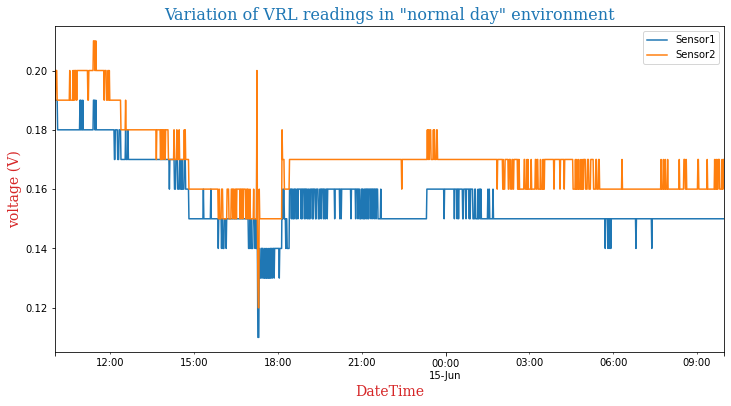

In [38]:
fdf = df[(df['date'] > '6/14/22 10:00 AM') & (df['date'] < '6/15/22 10:00 AM')]

ax = fdf.plot(x='date', y=["mq2_1","mq2_2"], 
              kind="line", figsize=(12, 6))

plt.title('Variation of VRL readings in "normal day" environment', fontdict=font_title)
plt.xlabel('DateTime',    fontdict=font)
plt.ylabel('voltage (V)', fontdict=font)
plt.legend(['Sensor1', 'Sensor2'], loc='best')


plt.show()


In [56]:
# MQ 2 Sensor 1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq2_1["mq2_1"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

for gas in GASES:
    mq2_1[gas] = ppm1[gas]

In [57]:
# MQ 2 Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq2_2["mq2_2"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]
 
ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

for gas in GASES:
    mq2_2[gas] = ppm2[gas]

In [58]:
mq2_1.describe()

,mq2_1,h2,lpg,ch4,co,alcohol,smoke,propane
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,0.156701,5.897428,3.147857,4.494610,17.233607,5.300723,10.036670,4.250276
std,0.011337,0.972037,0.527922,1.066445,4.592043,1.132451,2.024964,0.679936
min,0.110000,2.684195,1.413810,1.472188,4.958296,1.930714,3.857808,1.978312
25%,0.150000,5.314947,2.831426,3.852942,14.469446,4.619904,8.819999,3.843015
50%,0.150000,5.314947,2.831426,3.852942,14.469446,4.619904,8.819999,3.843015
75%,0.160000,6.131478,3.274181,4.711965,18.103169,5.545002,10.485711,4.415709
max,0.190000,8.984733,4.828359,8.070486,32.953557,9.033042,16.651872,6.401679


In [59]:
mq2_2.describe()

,mq2_2,h2,lpg,ch4,co,alcohol,smoke,propane
count,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000,1828.000000
mean,0.168961,5.897428,3.147857,4.494610,17.233607,5.300723,10.036670,4.250276
std,0.010568,0.972037,0.527922,1.066445,4.592043,1.132451,2.024964,0.679936
min,0.120000,2.684195,1.413810,1.472188,4.958296,1.930714,3.857808,1.978312
25%,0.160000,5.314947,2.831426,3.852942,14.469446,4.619904,8.819999,3.843015
50%,0.170000,5.314947,2.831426,3.852942,14.469446,4.619904,8.819999,3.843015
75%,0.170000,6.131478,3.274181,4.711965,18.103169,5.545002,10.485711,4.415709
max,0.210000,8.984733,4.828359,8.070486,32.953557,9.033042,16.651872,6.401679


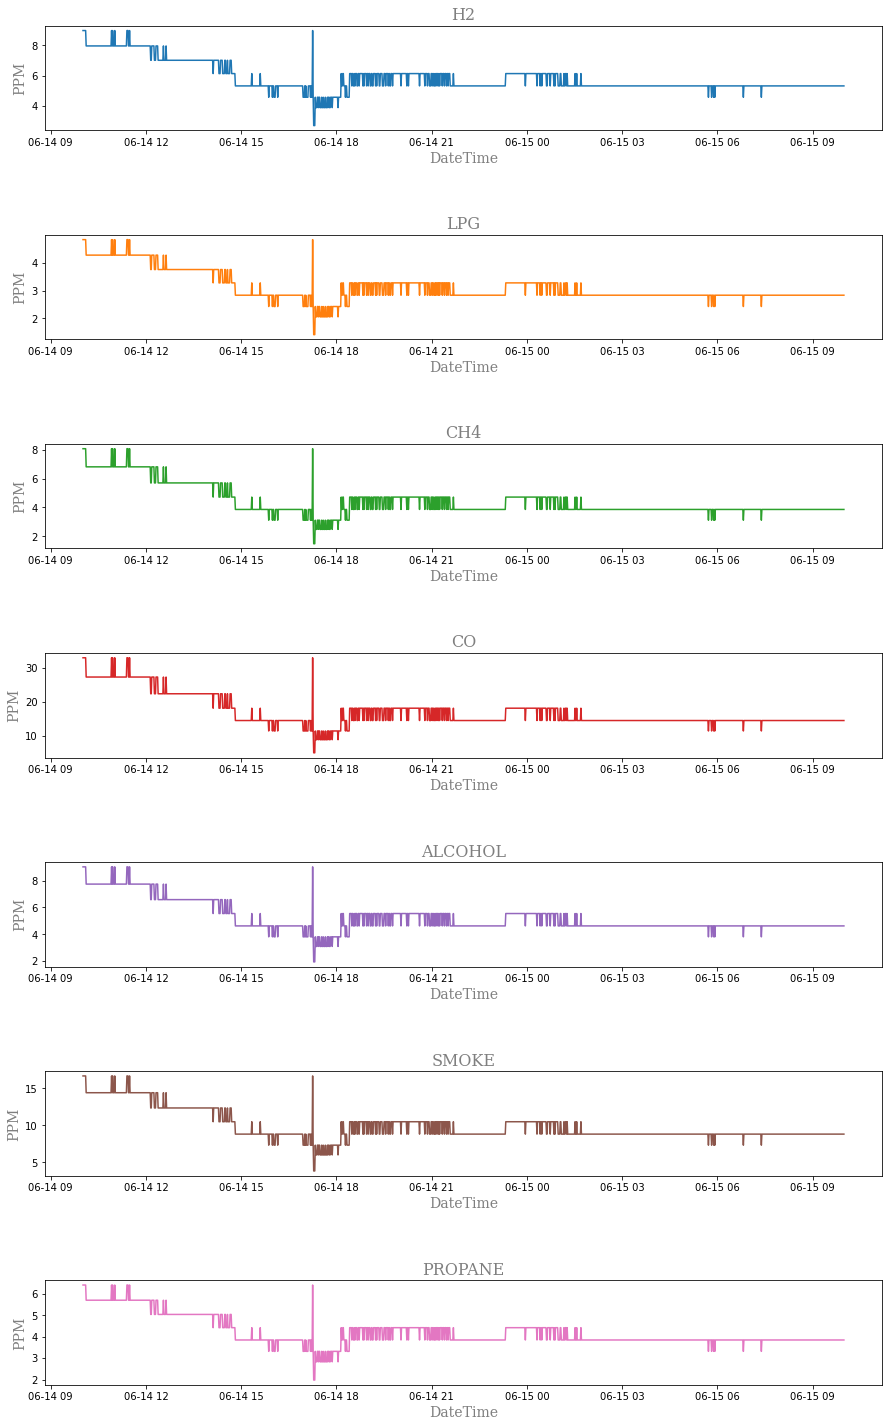

In [60]:
# Time Interval:
#           min: 2022-06-14 09:56:00
#           max: 2022-06-15 16:23:00 
  
fmq = mq2_1[(mq2_1['date'] > '6/14/22 10:00 AM') & (mq2_1['date'] < '6/15/22 010:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(711 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()




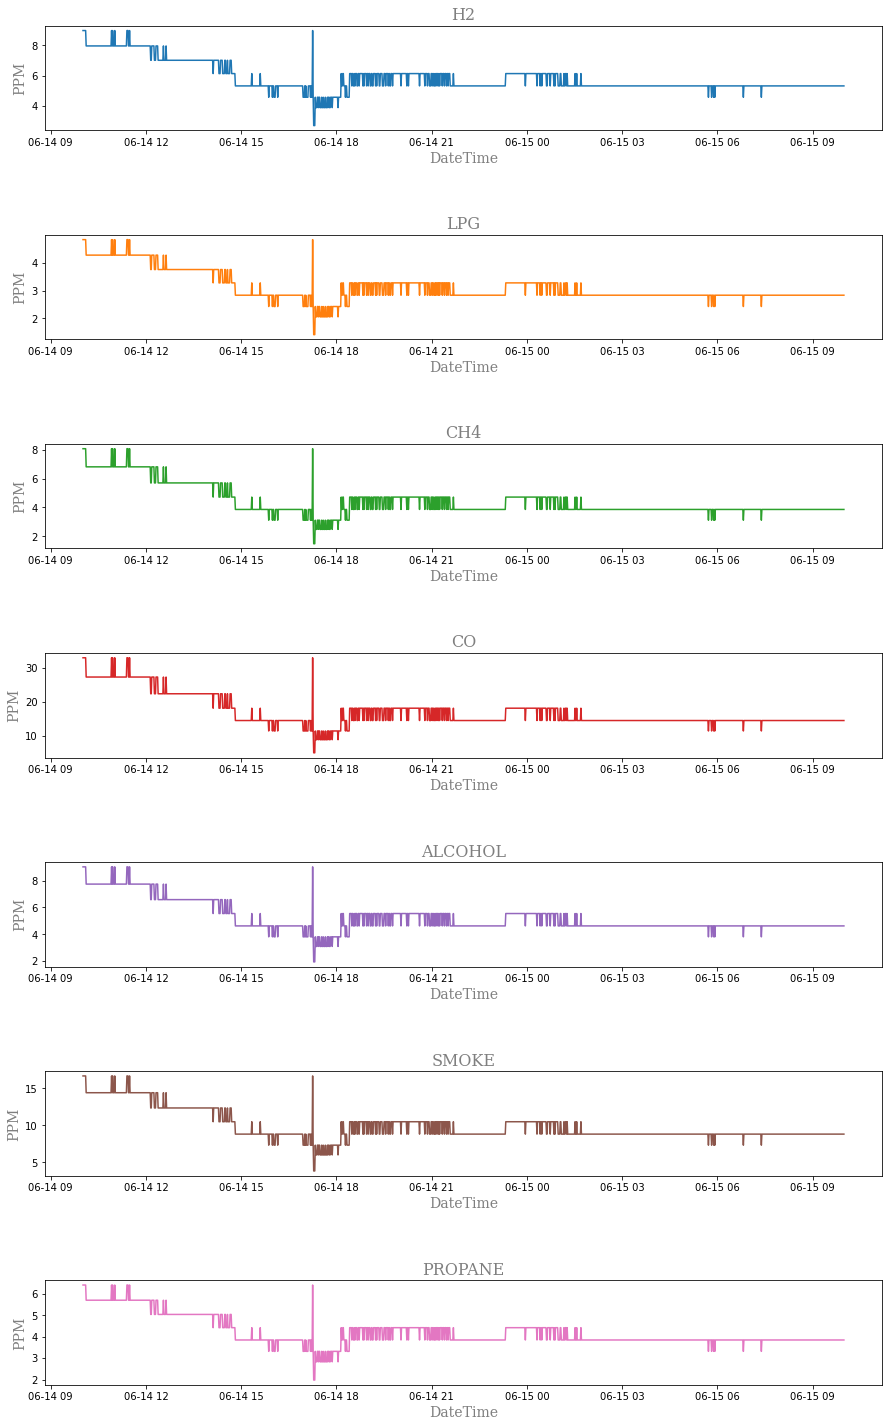

In [61]:
# Time Interval:
#           min: 2022-06-14 09:56:00
#           max: 2022-06-15 16:23:00 
  
fmq = mq2_2[(mq2_2['date'] > '6/14/22 10:00 AM') & (mq2_2['date'] < '6/15/22 010:00 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(711 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()

In [62]:
# Save in excel file
mq2_1.to_csv('mq2_1.csv')
mq2_2.to_csv('mq2_2.csv')